<a href="https://colab.research.google.com/github/CurtCalledBurt/AB-Demo/blob/master/Project_2_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

df = pd.read_csv('https://raw.githubusercontent.com/CurtCalledBurt/DS_Unit2_Build_Week/master/games.csv')

In [0]:
df.columns

Index(['id', 'type', 'name', 'yearpublished', 'minplayers', 'maxplayers',
       'playingtime', 'minplaytime', 'maxplaytime', 'minage', 'users_rated',
       'average_rating', 'bayes_average_rating', 'total_owners',
       'total_traders', 'total_wanters', 'total_wishers', 'total_comments',
       'total_weights', 'average_weight'],
      dtype='object')

In [0]:
# from the glossary I have been able to deduce that:

# traders is either:
# 1. the number of people who own the game and are willing to trade it, or
# 2. the number of people who want the game through trade, not purchase

# wanters are those who want the game through trade, typically
# wishers are those who want to buy the game

# a weight on the site is an abstract measure of how complex a game is, 
# this number ranges from 1 to 5
# So,

# total_weights is either: 
# 1. the total number of people have submitted a "weight" for the game or
# 2. the total number of all the weights submitted and added up,
# and

# average_weight is most likely an average of all the measures of weight
# submitted by users. This seems most likely as this column ranges from
# 1 to 5, like the weights themselves would.


column_names = {'yearpublished': 'year_published', 'minplayers': 'min_players',
               'maxplayers': 'max_players','playingtime': 'playtime',
                'minplaytime': 'min_playtime', 'maxplaytime': 'max_playtime', 
                'minage': 'min_age'}
df = df.rename(columns=column_names)

df = df.drop_duplicates()



# we copy this dataset before changing it to make a point about zeroes I'll explain later.
df_old = df.copy()

# The line of code below this giant block of text might be the most important line of code in the entire notebook.
# We have a lot of games that have no ratings and so their average rating is 0.
# If we don't purge the dataset of these games the model appears far more accuarate that it is
# because the only time that an average rating is 0 is when it has no user ratings. So the model
# doesn't really do any complicated prediction in that case, it just sees that a game has no ratings,
# and therefore mathematically has an average rating of 0.

# The project as presented here and in the blog post is a comparison of what happens when you do purge these zeroes
# versus what happens when you don't so
# I created a copy of the dataset with all the zeroes still in it to show what happens when you don't
# get rid of these rows.

df = df[df['users_rated'] > 0]

In [0]:
# feature selection

# We try predicting 'average_rating' and see what happens with that.
target = 'average_rating'

# Obviously we wouldn't know the bayes_average_rating if we knew the average rating, 
# so we remove that from the features. 

things_we_cannot_know = ['bayes_average_rating']

# we throw out any id's and otherwise not helpful information.
things_we_do_not_need = ['name', 'type', 'id']

# turns out max_playtime and playtime are the same column in all 
# entrees except for three of them, so we'll drop playtime too
redundant = ['playtime']

all_in_all = things_we_cannot_know + things_we_do_not_need + redundant


# we get the features we want
features = df.columns.drop([target] + all_in_all)
X = df[features]
y = df[target]

X_old = df_old[features]
y_old = df_old[target]

In [0]:
# train/test/val split, train and test for both zero'less set and 0 set

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2019)
X_train_old, X_test_old, y_train_old, y_test_old = train_test_split(X_old, y_old, random_state=2019)

In [0]:
# train/test/val split, train and val for zero'less set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=2019)
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((30994, 14), (30994,), (13776, 14), (13776,), (10332, 14), (10332,))

In [0]:
# train/test/val split for 0 set
X_train_old, X_val_old, y_train_old, y_val_old = train_test_split(X_train_old, y_train_old, random_state=2019)
X_train_old.shape, y_train_old.shape, X_test_old.shape, y_test_old.shape, X_val_old.shape, y_val_old.shape

((44697, 14), (44697,), (19866, 14), (19866,), (14900, 14), (14900,))

In [0]:
# quick and dirty baseline regressor
# note it returns a list the same size as the input

def baseline_Regressor(true, target):
  from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

  # making a list of the same size as 'target' 
  # with the mean of the target as the only possible entree
  mean_target = target.mean()
  pred_baseline = [mean_target] * len(true)
  
  #calculating baseline error and score
  mae = mean_absolute_error(true, pred_baseline)
  mse = mean_squared_error(true, pred_baseline)
  rmse = np.sqrt(mean_squared_error(true, pred_baseline))
  r2 = r2_score(true, pred_baseline)
  
  # printing the errors and scores
  return pred_baseline, mae, mse, rmse, r2

In [0]:
# get a list of baseline predictions and print errors and scores
y_pred_base, mae_base, mse_base, rmse_base, r2_base = baseline_Regressor(y_val, y_train)

print("Baseline MAE: ", mae_base)
print("Baseline MSE: ", mse_base)
print("Baseline RMSE: ", rmse_base)
print("Baseline R2 Score: ", r2_base)

Baseline MAE:  1.2361119756518884
Baseline MSE:  2.5345559673252773
Baseline RMSE:  1.5920288839481769
Baseline R2 Score:  -3.1208485159028854e-05


In [0]:
# RandomForest error function for model scoring

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def prediction_and_error(X_train_processed, y_train, pipeline, train_test_or_val):
    kind = train_test_or_val

    #make a prediction on the train set
    y_pred = pipeline.predict(X_train_processed)

    # MAE of train set
    mae = mean_absolute_error(y_train, y_pred)
    print(kind + ' MAE: ', mae)
    
    # MSE of train set
    rmse = mean_squared_error(y_train, y_pred)
    print(kind + ' MSE: ', rmse)
    
    # RMSE of train set
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    print(kind + ' RMSE: ', rmse)

    # R2 score of train set
    r2 = r2_score(y_train, y_pred)
    print(kind + ' R^2 Score: ', r2)
    
    return y_pred

In [0]:
# At this point we are going to do everything with the dataset that
# still has a ton of zeroes in it, and then we'll do everything again
# with the datasets have dropped the zeroes

In [0]:
# We're eventually going to use eli5, and
# Remember that eli5 doesn't play well with pipelines, so you need to make your
# model outside of a pipeline.

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer


# we make our imputer in a pipeline
processor = make_pipeline(
    SimpleImputer(strategy='median')
)

# we fit the processor onto the data
X_train_old_processed = processor.fit_transform(X_train_old)
X_val_old_processed = processor.transform(X_val_old)

# we make our model outside the pipeline
pipeline2 = RandomForestRegressor(
        n_estimators=150,
        max_depth=15,
        min_samples_leaf=20,
        random_state=2019,
        n_jobs=-1
)

# and fit our model to our processed data
pipeline2.fit(X_train_old_processed, 
              y_train_old);

In [0]:
# Print the Train error and R2 score of 0 set
print("Set with 0's left in")
y_pred_old = prediction_and_error(X_train_old_processed, y_train_old, pipeline2, 'Train')

Set with 0's left in
Train MAE:  0.5695378448368745
Train MSE:  0.9194754225655231
Train RMSE:  0.9588928107799761
Train R^2 Score:  0.9018608454756069


In [0]:
# Print the Val error and R2 Score of 0 set
print("Set with 0's left in")
y_pred_old = prediction_and_error(X_val_old_processed, y_val_old, pipeline2, 'Val')

Set with 0's left in
Val MAE:  0.6200689655100977
Val MSE:  1.058363634461102
Val RMSE:  1.0287680178062992
Val R^2 Score:  0.8862730132407871


In [0]:
# We check feature importance of the zero set 

feature_importances = pd.DataFrame(pipeline2.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',
                                    ascending=False)
feature_importances

,importance
users_rated,0.902862
total_wishers,0.032397
year_published,0.023530
average_weight,0.012759
total_owners,0.005632
min_age,0.004055
total_traders,0.003595
total_wanters,0.003449
max_playtime,0.002859
max_players,0.002798


In [0]:
# We check feature importance of the zero set and see that, rather counter
# intuitively the number of ratings is a very powerful feature in this model
# more so than any other by a large margin

In [0]:
# installing eli5 to make permutation tables and double check what 
# we've seen via the feature importance.
!pip install eli5

import eli5
from eli5.sklearn import PermutationImportance

In [0]:
# Permutation Table of 0 set

# create the permuter
permuter2 = PermutationImportance(
    pipeline2,
    scoring='neg_mean_absolute_error',
    n_iter=5,
    random_state=2019
)
# fit the permuter onto the data
permuter2.fit(X_val_old_processed, y_val_old);


# Curtis, remember that defining an eli5 permuter takes a model but no data. that's
# why your data encoders could be used in a pipeline, but your model couldn't;
# the model needs to get passed in at definition. The data does not. 

feature_names = X_val.columns.tolist()
pd.Series(permuter2.feature_importances_, feature_names).sort_values(ascending=False)

eli5.show_weights(
    permuter2, 
    top=None,
    feature_names=feature_names
)

Weight,Feature
2.1376 ± 0.0416,users_rated
0.1062 ± 0.0071,total_wishers
0.1031 ± 0.0035,year_published
0.0612 ± 0.0024,average_weight
0.0499 ± 0.0027,total_wanters
0.0366 ± 0.0012,total_traders
0.0242 ± 0.0019,total_owners
0.0109 ± 0.0015,min_age
0.0082 ± 0.0013,max_players
0.0067 ± 0.0010,max_playtime


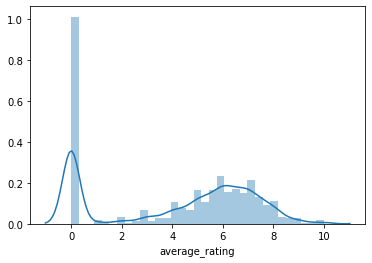

In [0]:
# Once again the number of ratings is clearly the most important
# feature to the model. Which feels weird. 

# When we explore with histograms, the issue becomes obvious very fast.

# histogram of average ratings
sns.distplot(df_old['average_rating']);

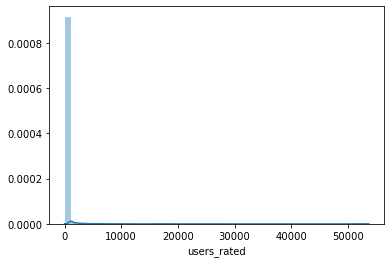

In [0]:
# histogram of number of ratings

sns.distplot(df_old['users_rated']);

In [0]:
# It looks like we have a ton of games with no ratings on them


# We get the exact number of these games
df_old[df_old['users_rated'] == 0].shape, df_old.shape

((24361, 20), (79463, 20))

In [0]:
# so a third-ish of our dataset has 0 ratings, which is a lot



# But with that information, now when we check how many
# games have zero average ratings, the problem becomes clear
df_old[df_old['average_rating'] == 0].shape

(24361, 20)

In [0]:
# for every 0 raters the average rating isn't inputted as a NaN like it probably should be,
# since the average of no values isn't defined, it's being inputted as zero.

# So those 0's in the data gives us a lot more accuracy and a much higher R2 score than 
# we really ought to be getting. all because 30% of our dataframe 
# has zeroes in users_rated if and only if the set has a zero in average_rating.
# And of course the model is picking up on that info and using it!

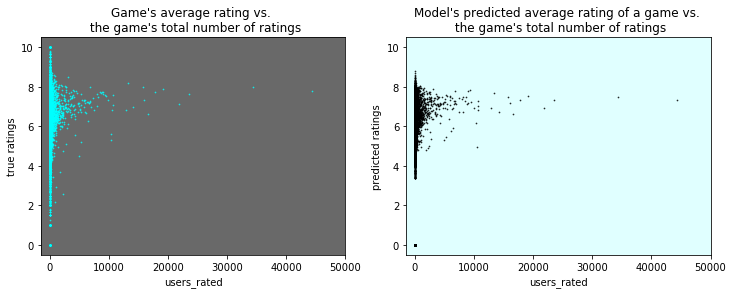

In [0]:
# When I first tried to find what was going on with the users_rated column, I used a scatter plot
# of users_rated vs average_rating

# this is almost useless in this case because the scatter plot
# hides all the 0 user ratings with 0 average ratings (a third of our data) 
# all in one point at the origin (0,0)

# we create the plot figure
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12, 4))
ax1.set_facecolor('dimgray')
ax2.set_facecolor('lightcyan')

# Zoom in on True val vs users
sns.regplot(X_val_old['users_rated'], y_val_old, 
            fit_reg = False, 
            scatter_kws={'color': 'cyan', 
                         's': .5}, 
            ax=ax1);

# Zoom in on Pred val vs users
sns.regplot(X_val_old['users_rated'], y_pred_old, 
            fit_reg = False, 
            scatter_kws={'color': 'black',
                         's': .5}, 
            ax=ax2);

ax1.set(title = "Game's average rating vs. \n the game's total number of ratings",
        ylabel='true ratings', 
        xlim=(-1_500, 50_000),
        ylim=(-0.5, 10.5)
       )
ax2.set(title="Model's predicted average rating of a game vs. \n the game's total number of ratings",
        ylabel='predicted ratings',
        xlim=(-1_500, 50_000),
        ylim=(-0.5, 10.5)
       )
plt.show()

In [0]:
# We repeat the same process but now with the datasets that have had the zeroes removed



# we process the data and fit onto a model with the zero'less set

# we make our imputer in a pipeline
processor = make_pipeline(
    SimpleImputer(strategy='median')
)

# we fit the processor onto the data
X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

# we make our model outside the pipeline
pipeline = RandomForestRegressor(
        n_estimators=150,
        max_depth=15,
        min_samples_leaf=20,
        random_state=2019,
        n_jobs=-1
)

# and fit our model to our processed data
pipeline.fit(X_train_processed, y_train);

In [0]:
# Print the Train error and R2 score of zero'less set
print("Set with 0's removed")

y_pred = prediction_and_error(X_train_processed, y_train, pipeline, 'Train')

Set with 0's removed
Train MAE:  0.812787487935968
Train MSE:  1.2895384916984387
Train RMSE:  1.1355784832843738
Train R^2 Score:  0.4838003737793096


In [0]:
# Print the Val error and R2 Score of zero'less set
print("Set with 0's removed")

y_pred = prediction_and_error(X_val_processed, y_val, pipeline, 'Val')


# For comparison here is the baseline error
# Baseline on Val set
# Baseline MAE:  1.2361119756518884
# Baseline MSE:  2.5345559673252773
# Baseline RMSE:  1.5920288839481769
# Baseline R2 Score:  -3.1208485159028854e-05

Set with 0's removed
Val MAE:  0.9005604799245981
Val MSE:  1.5812322210706695
Val RMSE:  1.2574705646935318
Val R^2 Score:  0.37611100748282


In [0]:
# We check feature importance of the zero'less set

feature_importances = pd.DataFrame(pipeline.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',
                                    ascending=False)
feature_importances

,importance
total_wishers,0.331445
year_published,0.244283
average_weight,0.125249
total_owners,0.052848
min_age,0.036574
total_traders,0.036209
total_wanters,0.033013
max_players,0.032531
max_playtime,0.028783
min_playtime,0.022413


In [0]:
# and now things are much more reasonable and much more in line with
# what we'd expect to be closer to reality now that we've removed
# a bunch of basically useless zeroes.

In [0]:
# Permutation Table of zero'less set

# we create the permuter
permuter = PermutationImportance(
    pipeline,
    scoring='neg_mean_absolute_error',
    n_iter=5,
    random_state=2019
)

# Now the data for the zero'less set gets passed in.
permuter.fit(X_val_processed, y_val);

feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

eli5.show_weights(
    permuter, 
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.1514 ± 0.0082,year_published
0.1472 ± 0.0089,total_wishers
0.0999 ± 0.0029,average_weight
0.0709 ± 0.0030,total_wanters
0.0538 ± 0.0042,total_traders
0.0296 ± 0.0041,total_owners
0.0138 ± 0.0017,min_age
0.0134 ± 0.0025,max_players
0.0100 ± 0.0018,max_playtime
0.0090 ± 0.0011,total_comments


In [0]:
# this table tells us what we expect to be true, things like a game being new or desired by a bunch of people
# tends to be a good indicator of how high or low it's rating is going to be

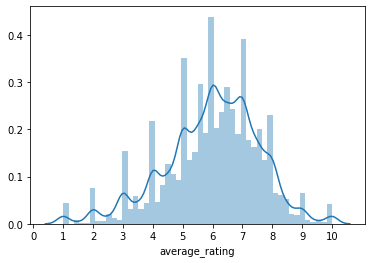

In [0]:
# average ratings excluding zeroes

fig, ax = plt.subplots()

sns.distplot(y_train, ax=ax)
ax.set(xticks=range(0,11,1))
plt.show()

In [0]:
# Now we can actually see some nuance to the ratings, 
# as opposed to it being dominated by zeroes.

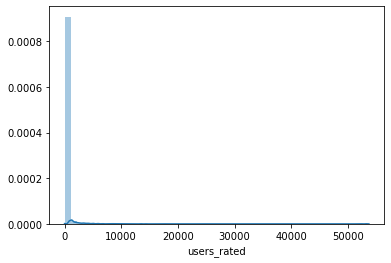

In [0]:
# number of ratings excluding zeroes

fig, ax = plt.subplots()

sns.distplot(X_train['users_rated'], ax=ax)
plt.show()

In [0]:
# This one didn't do much but that's because the spread of users_rated is a lot 
# bigger than that of average_rating, so the zeroes got clumped together with
# a lot of the smaller values into one bar, so we don't see much of a change
# when we remove the zeroes from this one.

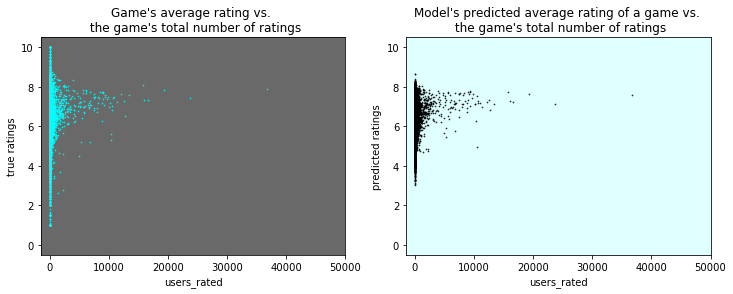

In [0]:
# we create the useless scatter plots for the zero'less set to prove one
# final point.

#we create the plot figure
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12, 4))
ax1.set_facecolor('dimgray')
ax2.set_facecolor('lightcyan')

# Scatter Plot of the true average rating vs users_rated in val set
sns.regplot(X_val['users_rated'], y_val, 
            fit_reg = False, 
            scatter_kws={'color': 'cyan', 
                         's': .5}, 
            ax=ax1);

# Scatter Plot of the Predicted average rating vs users_rated in val set
sns.regplot(X_val['users_rated'], y_pred, 
            fit_reg = False, 
            scatter_kws={'color':'black', 
                         's': .5}, 
            ax=ax2);

ax1.set(title = "Game's average rating vs. \n the game's total number of ratings",
        ylabel='true ratings', 
        xlim=(-1_500, 50_000),
        ylim=(-0.5, 10.5)
       )
ax2.set(title="Model's predicted average rating of a game vs. \n the game's total number of ratings",
        ylabel='predicted ratings',
        xlim=(-1_500, 50_000),
        ylim=(-0.5, 10.5)
       )
plt.show()

In [0]:
# It's kind of cool how somthing so pivitol can be so hidden with the wrong plots.
# If we compare these scatter plots of our true values vs predicted values with
# the set wtih the zeroes still in them they look almost identical, and that is because
# all we've functionally removed from the first scatter plots to get these ones 
# is that tiny dot that was formally at (0,0).


# In general scatter plots do a terrible job of helping us see this problem because they
# measure the number of unique entrees. But if we have the same value over and over and over
# again, the scatter plot is blind to that.

# Pick your visualizations CAREFULLY.